In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
import os
import glob
import torch
from theoretical_analysis.nonnegative_pca_analysis import (
    generate_nnpca_matrix,
    c_critical,
    c_for_step_function,
)
from theoretical_analysis import plot_step_function, beta_to_sigma, step_function
from learning_from_data.train import NNTrainingModule
import scipy.optimize as spo
import pickle
import matplotlib
from pathlib import Path

log_dir = Path("logs/")
plot_dir = Path("plots/")
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.serif"] = ["Computer Modern Roman"]
matplotlib.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath} \usepackage{amssymb} \usepackage{mathptmx}"
)

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


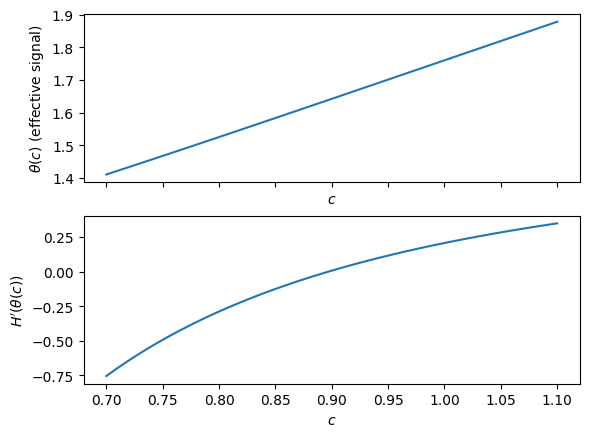

0.8973655838650303

In [2]:
# sigma=tanh(x)
sigma = lambda x: np.tanh(x)
c_critical(c_range=[0.7, 1.1], sigma=sigma, sigma_image=[-1, 1], plot=True)

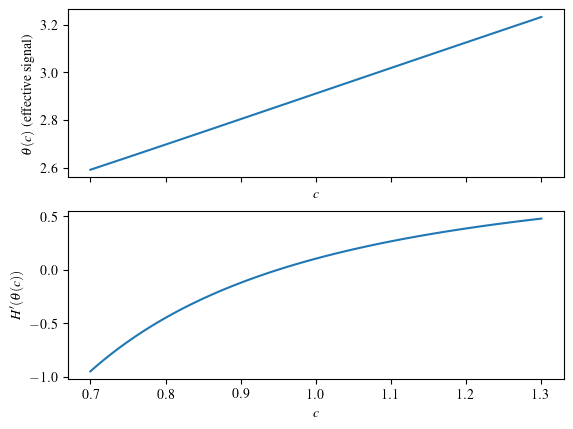

0.9493652294138882

In [3]:
# sigma=sgn(x)+1
c_for_step_function(beta=[0, 2], c_range=[0.7, 1.3], plot=True)

In [8]:
def sigma_3params(x, gamma, alpha=1):
    a, b, c = gamma
    if x < c:
        return 0
    if x >= c and x <= c + a:
        return b * ((x - c) / a) ** (1 / alpha)
    if x > c + a:
        return b

In [4]:
# run blackbox optimization to find best gamma's (fixing alpha=1)
def find_c_for_parametrized_sigma(beta):
    """Given parameter for the parametrized sigma function, compute c_critical."""
    c = c_critical(
        [0.3, 1.5], sigma=lambda x: sigma_3params(x, beta), sigma_image=[0, beta[1]], plot=False
    )
    print(f"beta={beta}, c_critical={c}")
    return c


pickle_file = "optimization_result.pkl"
try:
    with open(pickle_file, "rb") as f:
        res = pickle.load(f)
except FileNotFoundError:
    res = spo.minimize(find_c_for_parametrized_sigma, [2, 2, -1], method="Nelder-Mead")
    with open(pickle_file, "wb") as f:
        pickle.dump(res, f)

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improveme

beta=[ 2.  2. -1.], c_critical=0.9109656211385301
beta=[ 2.1  2.  -1. ], c_critical=0.9075093775132698
beta=[ 2.   2.1 -1. ], c_critical=0.9107170019091426
beta=[ 2.    2.   -1.05], c_critical=0.9129185938403679
beta=[ 2.06666667  2.06666667 -0.95      ], c_critical=0.9067521242544897
beta=[ 2.1  2.1 -0.9], c_critical=0.9041076831435929
beta=[ 2.13333333  2.13333333 -0.93333333], c_critical=0.904098341453573
beta=[ 2.2  2.2 -0.9], c_critical=0.9013710670031287
beta=[ 2.26666667  2.1        -0.86666667], c_critical=0.8986480182215018
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/tmp/ipykernel_2912398/234273912.py", line 13, in <module>
    with open(pickle_file, "rb") as f:
  File "/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 286, in _modified_open
    return io_open(file, *args, **kwargs)
FileNotFoundError: [Errno 2] No such file or directory: 'optimization_result.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2912398/234273912.py", line 16, in <module>
    res = spo.minimize(find_c_for_parametrized_sigma, [2, 2, -1], method="Nelder-Mead")
  File "/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/optimize/_minimize.py", line 701, in minimize
    res = _minimize_neldermead(fun,

# Blackbox optimization on step functions

In [4]:
def minimize_with_random_initial_simplex(n=20, seed=0):
    # define bounds for the parameters in optimization
    bounds = (
        [(None, None)] + [(0, None) for _ in range(1, n + 1)] + [(0, None) for _ in range(0, n + 1)]
    )
    # define initial simplex for Nelder-Mead
    rng = np.random.default_rng(seed)
    N = 2 * n + 2  # N parameters, need N+1 points to define the initial simplex
    simplex = rng.uniform(
        0, 1, (N + 1, N)
    )  # set each incremental parameter to be uniformly random in [0,1]
    simplex[:, 0] = rng.uniform(
        -5, 0, N + 1
    )  # set x0(the first parameter) to be uniformly random in [-5,0]
    # run minimization
    historic_xks = []
    historic_funs = []

    def callback_function(intermediate_result):
        historic_xks.append(intermediate_result.x)
        historic_funs.append(intermediate_result.fun)

    res = spo.minimize(
        lambda beta: c_for_step_function(beta, c_range=[0.5, 1.5], tol=1e-12, plot=False),
        x0=np.zeros(2 * n + 2),
        method="Nelder-Mead",
        bounds=bounds,
        callback=callback_function,
        options={"initial_simplex": simplex},
    )
    return historic_xks, historic_funs, res

In [4]:
# n = 15
file = log_dir / "nnpca_optimization_result_NM_n=15.pkl"
try:
    with open(file, "rb") as f:
        results = pickle.load(f)
except FileNotFoundError:
    results = {}
for seed in range(10):
    if str(seed) in results:
        continue
    historic_xks, historic_funs, res = minimize_with_random_initial_simplex(n=15, seed=seed)
    results[str(seed)] = [historic_xks, historic_funs, res]
    with open(file, "wb") as f:
        pickle.dump(results, f)

results_list = [results[str(seed)][2].fun for seed in range(10)]
argmin_seed = np.argmin(results_list)
print(results_list)
print(results_list[argmin_seed])
plot_step_function(np.array(results[str(argmin_seed)][2].x), plot_dir / "step_function_NM_n=15.pdf")

1.3015360537410743
1.5
1.5
1.5
1.1123150757648546
1.5
1.5
1.3783977796756517
1.5
1.5
1.5
1.138640722982018
1.5
1.5
1.141089463415483
1.5
1.5
0.907777208247353
1.5
1.2440904146878893
1.5
0.9159483733292291
1.5
1.5
1.2112980924557633
1.0334710888728296
0.9908771763166442
1.5
1.5
1.2297517978822725
1.5
1.5
1.3688010110181494
1.3961262271750456
1.5
1.5
0.9196377390562702
0.9426215096955275
1.0022762127209717
0.9976738875757292
1.013169313528124
1.0064457091993972
1.065665202882883
1.071879767545397
1.0647716546354786
1.0955731807425764
1.1268880560728576
1.1085101239350479
1.1226358511867147
1.41890234028142
1.5
1.206506325643204
1.4846245307107893
1.2824257927986764
1.5
1.2106223201608373
1.5
1.224795082509445
1.1540863360769436
1.2969509328304412
1.3447596535243065
1.4205359816896816
1.4324594318986783
1.4788132599696837
1.4031863169093413
1.5
1.37615558879952
1.262981147499886
0.9176335238316824
0.9477253994427883
0.9354351930687699
0.8901391086965305
0.9724880398625828
0.90760013827639

KeyboardInterrupt: 

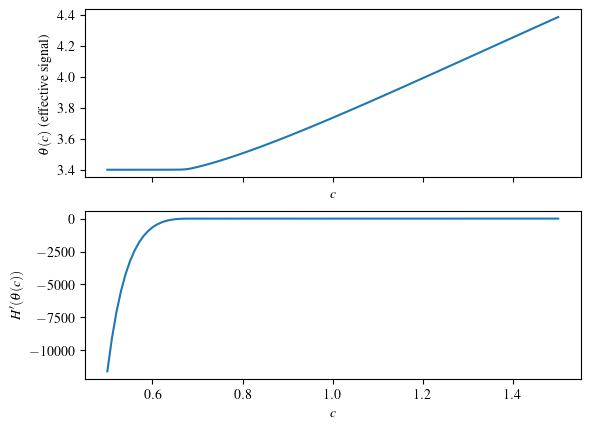

0.8878551260542908


0.8878551260542908

In [6]:
# starting from tanh
n = 15
x = np.linspace(-5, 5, n + 1)
y = 1.7 * np.tanh(0.58 * x) + 1.7
y = np.concatenate([[0], y])
y[-1] = 3.4
a = np.ones(n + 1) * (10 / n)
a[0] = -5
b = y[1:] - y[:-1]
beta0 = np.concatenate([a, b])
c_for_step_function(beta0, [0.5, 1.5], plot=True)

0.8778287612254251


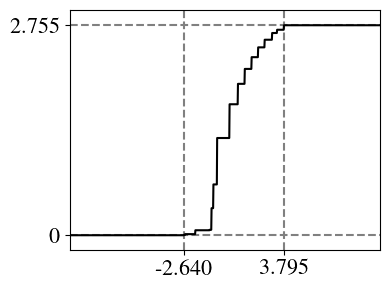

In [4]:
file = log_dir / "nnpca_optimization_result_NM_tanh.pkl"
try:
    with open(file, "rb") as f:
        res = pickle.load(f)
except FileNotFoundError:
    bounds = (
        [(None, None)] + [(0, None) for _ in range(1, n + 1)] + [(0, None) for _ in range(0, n + 1)]
    )
    res = spo.minimize(
        lambda beta: c_for_step_function(beta, c_range=[0.5, 1.0], tol=1e-12, plot=False),
        x0=beta0,
        method="Nelder-Mead",
        bounds=bounds,
    )
    with open(file, "wb") as f:
        pickle.dump(res, f)
print(res.fun)
plot_step_function(res.x, plot_dir / "nnpca_step_function_NM_tanh.pdf")

# Transferability analysis

In [7]:
# Use sigma learned from NNPCA, apply to Planted Submatrix
from theoretical_analysis.planted_submatrix_analysis import (
    c_for_step_function as c_for_step_function_planted_submatrix,
)

print(c_for_step_function_planted_submatrix(res.x, c_range=[0.5, 1.5], plot=False))

0.7611044537531205


0.7548989351116688


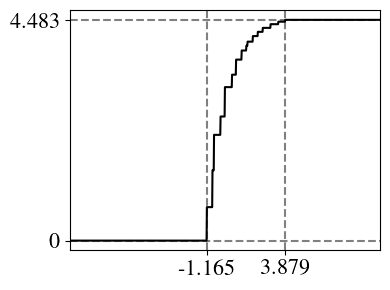

0.8797959412974329
0.8797959412974329


In [10]:
# Use sigma learned from planted submatrix, apply to NNPCA
file = log_dir / "optimization_result_NM_n=15.pkl"
with open(file, "rb") as f:
    results = pickle.load(f)

results_list = [results[str(seed)][2].fun for seed in range(10)]
argmin_seed = np.argmin(results_list)
print(results_list[argmin_seed])
beta = np.array(results[str(argmin_seed)][2].x)
plot_step_function(beta, plot_dir / "step_function_NM_n=15.pdf")
print(c_for_step_function(beta, c_range=[0.5, 1.5], plot=False))

# Phase transition for eigenvalue and eigenvectors

In [5]:
sigma = beta_to_sigma(res.x)

In [17]:
n = 2000
N = 100
np.random.seed(0)
betas = np.arange(0, 3, 0.05)
try:
    results = pickle.load(open(log_dir / f"nnpca_top_eigen_n={n}_N={N}.pkl", "rb"))
except FileNotFoundError:
    results = {}
for beta in betas:
    if beta in results:
        continue

    A_p_evals = np.zeros(N)
    L_p_evals = np.zeros(N)
    A_p_evecs = np.zeros(N)
    L_p_evecs = np.zeros(N)

    for i in range(N):
        A_p, y = generate_nnpca_matrix(n, beta)
        eval, evec = np.linalg.eigh(A_p)
        A_p_evals[i], A_p_evecs[i] = eval[-1], (evec[:, -1] * y).sum() ** 2
        L_p = A_p + np.diag(step_function(sigma, A_p.sum(axis=1)))
        eval, evec = np.linalg.eigh(L_p)
        L_p_evals[i], L_p_evecs[i] = eval[-1], (evec[:, -1] * y).sum() ** 2

    results[beta] = [A_p_evals, A_p_evecs, L_p_evals, L_p_evecs]
    pickle.dump(results, open(log_dir / f"nnpca_top_eigen_n={n}_N={N}.pkl", "wb"))
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
ax[0].plot(
    betas,
    [results[beta][0].mean() for beta in betas],
    label=r"Direct spectral algorithm $\sigma(x)=0$",
    color="#648fff",
)
ax[0].fill_between(
    betas,
    [results[beta][0].mean() - results[beta][0].std() for beta in betas],
    [results[beta][0].mean() + results[beta][0].std() for beta in betas],
    alpha=0.3,
    color="#648fff",
)
ax[0].plot(
    betas,
    [results[beta][2].mean() for beta in betas],
    label=r"Nonlinear Laplacian $\sigma(x)=a\tanh(bx)$",
    color="#fe6100",
)
ax[0].fill_between(
    betas,
    [results[beta][2].mean() - results[beta][2].std() for beta in betas],
    [results[beta][2].mean() + results[beta][2].std() for beta in betas],
    alpha=0.3,
    color="#fe6100",
)
ax[1].plot(
    betas,
    [results[beta][1].mean() for beta in betas],
    label=r"Direct spectral algorithm $\sigma(x)=0$",
    color="#648fff",
)
ax[1].fill_between(
    betas,
    [results[beta][1].mean() - results[beta][1].std() for beta in betas],
    [results[beta][1].mean() + results[beta][1].std() for beta in betas],
    alpha=0.3,
    color="#648fff",
)
ax[1].plot(
    betas,
    [results[beta][3].mean() for beta in betas],
    label=r"Nonlinear Laplacian $\sigma(x)=a\tanh(bx)$",
    color="#fe6100",
)
ax[1].fill_between(
    betas,
    [results[beta][3].mean() - results[beta][3].std() for beta in betas],
    [results[beta][3].mean() + results[beta][3].std() for beta in betas],
    alpha=0.3,
    color="#fe6100",
)

ax[0].vlines(1, 0, 5, linestyle="--", color="#648fff")
ax[0].vlines(res.fun, 0, 5, linestyle="--", color="#fe6100")
ax[1].vlines(1, 0, 1, linestyle="--", color="#648fff")
ax[1].vlines(res.fun, 0, 1, linestyle="--", color="#fe6100")

ax[0].text(1, 5.1, r"$\beta^*=1$", color="black", ha="left", fontsize=8)
ax[0].text(res.fun, 5.1, rf"$\beta^*={res.fun:.3f}$", color="black", ha="center", fontsize=8)

ax[0].set_ylim(1, 5)
ax[1].set_ylim(0, 1)
ax[0].set_ylabel(r"$\lambda_1(L)$")
ax[1].set_ylabel(r"$\langle {v}_1(L), {x} \rangle^2$")
ax[1].set_xlabel(r"$\beta$")
ax[0].set_xticklabels([])
ax[1].tick_params(axis="x", labelsize=8)
ax[0].tick_params(axis="y", labelsize=8)
ax[1].tick_params(axis="y", labelsize=8)

plt.legend(loc="lower right")
plt.savefig(plot_dir / "eigenvectors.pdf")
plt.tight_layout()
plt.show()

# Analyze learned model

In [13]:
log_dir = "/cis/home/yma93/projects/gnn-planted-clique/learning_from_data/custom_laplacian"


def analyze_runs(task, model):
    api = wandb.Api()
    runs = api.runs("yuxinma/custom_laplacian")
    id_list = []
    for run in runs:
        if run.config["task"] == task and run.config["model"]["model"] == model:
            id_list.append(run.id)

    for run_id in id_list:
        fname = glob.glob(os.path.join(log_dir, f"{run_id}/checkpoints/epoch*"))[0]
        best_model = NNTrainingModule.load_from_checkpoint(fname, map_location=None)
        best_model.eval()

        def learned_sigma(x):
            if isinstance(x, (int, float)):
                x_tensor = torch.tensor(x).reshape(1, 1).float().to(best_model.device)
                return best_model.model.mlp(x_tensor).detach().item()
            if isinstance(x, torch.Tensor) and x.dim() == 1:
                x_tensor = x.reshape(-1, 1).float().to(best_model.device)
                return best_model.model.mlp(x_tensor).detach().squeeze().cpu().numpy()

        test_xs = torch.linspace(-100, 100, 1000)
        image = [learned_sigma(test_xs).min().item(), learned_sigma(test_xs).max().item()]
        print(run_id, c_critical([0.7, 1.5], learned_sigma, sigma_image=image, plot=True))
    return id_list

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


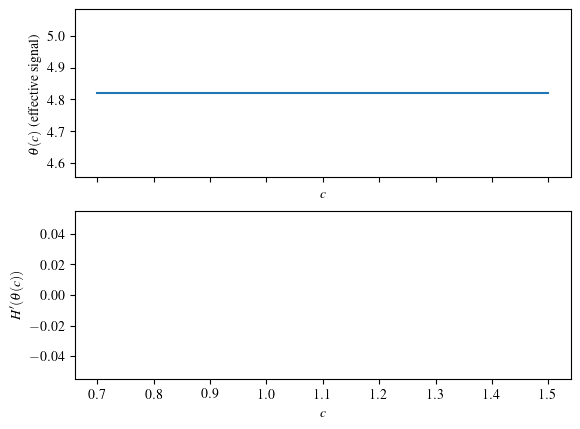

9nuv1jtl 1.5


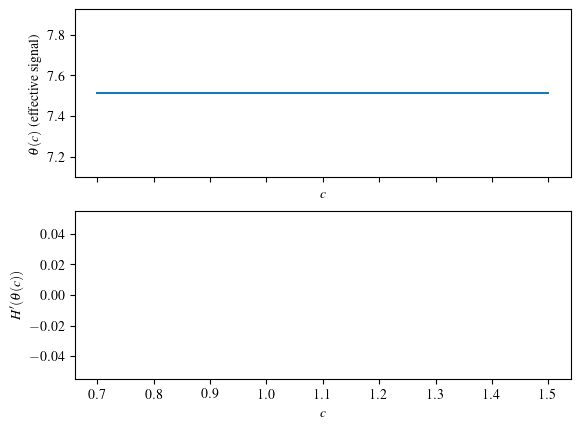

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


3fylhb9b 1.5


/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


KeyboardInterrupt: 

In [14]:
analyze_runs("nonnegative_pca", "tanh")